# Entropy of the relaxed (Gumbel-Softmax) one-hot categorical variables

### References

[1] Maddison, Chris J., Andriy Mnih, and Yee Whye Teh. "The concrete distribution: A continuous relaxation of discrete random variables." arXiv preprint arXiv:1611.00712 (2016).

[2] Jang, Eric, Shixiang Gu, and Ben Poole. "Categorical reparameterization with gumbel-softmax." arXiv preprint arXiv:1611.01144 (2016).

### Context

Let's consider a VAE with 
decoder $x \sim p(x|z)$
and encoder $z \sim q(z|x)$, where $q(z|x)$ is a learned categorical distribution. 
The distribution $q$ is optimized with gradients of the ELBO objective:
$$\mathcal{L} = \mathbb{E}_{q(z|x)}\left(\log p(x|z)\right) - \mathbb{KL}(p|q) = \mathbb{E}_{\log q(z|x)}\left(\log  p(x|z) p(z)\right) + \mathbb{H}(q)$$

We below study three relaxations of the entropy term of the above variational objective. The relaxations we denote by numbers of the respective equations (see [1]): 
 - Maddison Eq. 21
 - Maddison Eq. 22
 - Concrete/Gumbel - an approach were we replace the discrete model with a fully relaxed continous one 

For Maddison 21/22 the optimized objective may look like a valid ELBO. But what's actually optimized with gradients is a relaxed variant of it.
By optimizing Maddison 21 and 22, we optimize some relaxed models that only in temperature limit converge to the discrete one. 

In both cases, the relaxed models (and in consequence gradients and optimization) are different from each other and from how it would go for REINFORCE. Then, since we can get fast estimates of H(q) for both of them (as shown below), what matters in the end is the final performance (and perhaps if gradients w.r.t encoder & decoder params are close to the REINFORCE gradients).

### Gradients 

 We have: (1) gradient of $\log p(x|z)$ term w.r.t to both encoder's and decoder's parameters; (2) gradient of KL/H w.r.t $q$'s (=encoder's) parameters.

(1) For gradient of $\log p(x|z)$ w.r.t to decoder's parameters, $z$-s are 'inputs' and whenever we use discretized $z$ e.g. $ST(z)$ (straight-through), we get the 'right' gradient. On the other hand, we always obtain a biased gradient w.r.t encoder's parameters.

(2) For the latter (gradient of KL/H w.r.t $q$'s parameters), we get gradient for one or another approximation: we calculate log prob for relaxed samples with discretized $\tilde{q}$ or relaxed distribution $q$.

For Maddison 22 when applied with ST: for $ST(z)$ we get the 'right' gradient for decoder's part and we get the 'right' gradient w.r.t $q$'s params, when we directly create discrete distribution $\tilde{q}$ from logits of $q$ and then, calculate $\nabla_\text{logits} H(q(\text{logits}))$ for a discrete $\tilde{q}$. The problem of biased gradients remains only when calculating gradient of $\log p(x|z)$ w.r.t encoder's parameters

### Side-note on MDNF

We get gradients of relaxed KL/H for MDNF as well - no true discrete model either. It's however harder to see, since relaxation is in $ST(\mu)$ (where $\mu$-s are shifts of the probability mass).

### Imports

In [1]:
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.2.0'

In [4]:
import tensorflow_probability as tfp

In [5]:
tfp.__version__

'0.9.0'

### Sample categorical distirbution

In [6]:
# Let's consider a 1D categorical variable with 4 possible outcomes
probs = np.array([0.5, 0.25, 0.125, 0.125], dtype='float32')

### MC estimate of the discrete distribution entropy

In [7]:
# Let's draw 10k samples from the discrete distribution 
dc = tfp.distributions.OneHotCategorical(logits=tf.math.log(probs))
z = dc.sample(10000)

In [8]:
# We count frequencies
tf.reduce_mean(tf.cast(z, 'float32'), 0)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.5016, 0.2504, 0.1238, 0.1242], dtype=float32)>

In [9]:
# get -entropy using MC
tf.reduce_mean(dc.log_prob(z))

<tf.Tensor: shape=(), dtype=float32, numpy=-1.2105174>

### Relaxed distributions with the same logits

In [10]:
# sample from relaxed distribution with some temperature
dr = tfp.distributions.RelaxedOneHotCategorical(logits=tf.math.log(probs), temperature=10.)
z = dr.sample(10000)

In [11]:
# the same but for lower temperature
dr1 = tfp.distributions.RelaxedOneHotCategorical(logits=tf.math.log(probs), temperature=1.0)
z1 = dr1.sample(10000)

In [12]:
# count relaxed 'frequencies' - proportions are off - but they are approaching the right one as temp->0
tf.reduce_mean(tf.cast(z, 'float32'), 0), tf.reduce_mean(tf.cast(z1, 'float32'), 0)

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.27209237, 0.2540716 , 0.23703194, 0.23680474], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.42032045, 0.25872633, 0.16158636, 0.15936734], dtype=float32)>)

**For a relaxed distribution we can get a discrete distribution by simply taking logits from the relaxed ones and 
samples from the discrete distribution will follow the same distribution as rounded (discretized) samples from the relaxed one [1]:**

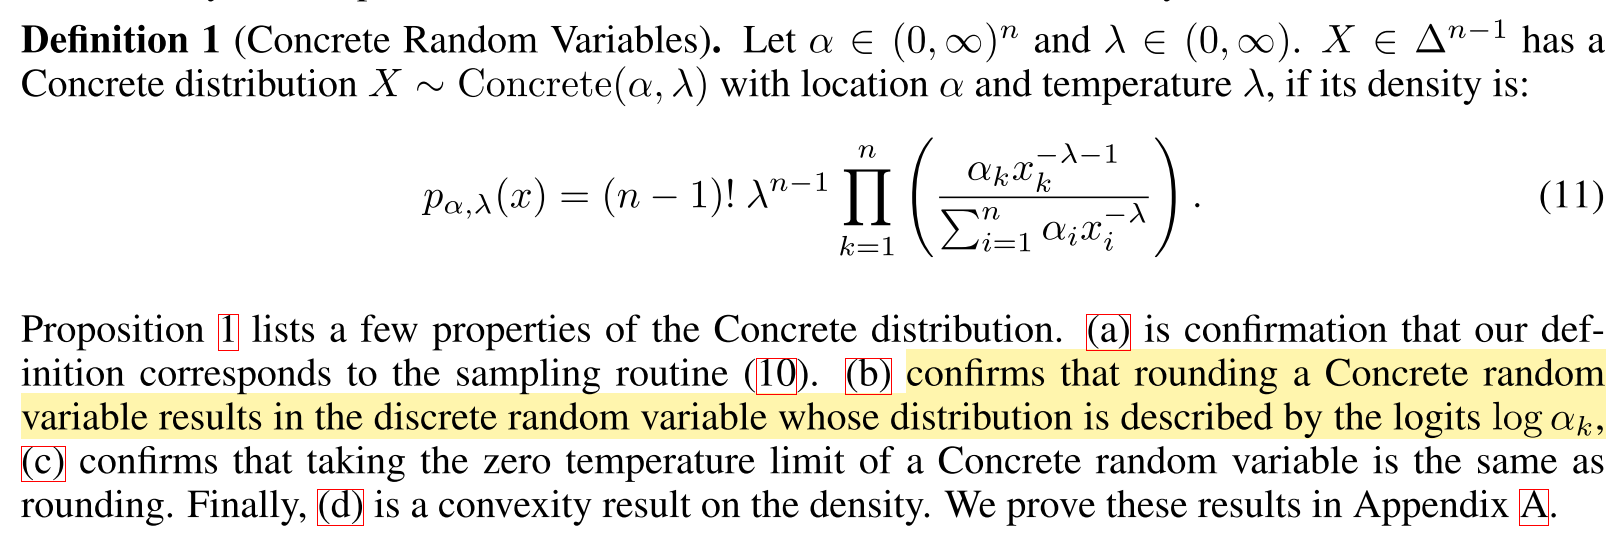

In [13]:
# discretize and then count - we get the right proportions!
z_discretized = tf.one_hot(tf.argmax(z, -1), 4)
tf.reduce_mean(tf.cast(z_discretized, 'float32'), 0)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.4974, 0.2538, 0.1267, 0.1221], dtype=float32)>

In [14]:
z1_discretized = tf.one_hot(tf.argmax(z1, -1), 4)
tf.reduce_mean(tf.cast(z1_discretized, 'float32'), 0)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.5002, 0.2467, 0.1269, 0.1262], dtype=float32)>

### Estimates of entropy of relaxed distribution and of discrete distribution with discretized samples

Let's look at entropy values (of the KL div part of ELBO):

In [15]:
# we can get the quick and correct MC estimate of H(discrete q) 
# by pushing discretized (eg ST(z)) to the discrete distro 
tf.reduce_mean(dc.log_prob(z_discretized)), tf.reduce_mean(dc.log_prob(z1_discretized))

(<tf.Tensor: shape=(), dtype=float32, numpy=-1.2139834>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.2150229>)

In [16]:
# MADDISON21 (with MC) measures log_prob for continous samples. 
# but let's note that for optimization it does not matter if we discretize (ST) z or not
# gradients w.r.t logits of q (encoder params) will be the same
# what's more crucial is that it approaches the right value as temp->0
tf.reduce_mean(dc.log_prob(z)), tf.reduce_mean(dc.log_prob(z1))  

(<tf.Tensor: shape=(), dtype=float32, numpy=-1.5261327>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.317418>)

In [17]:
# note however that gradients w.r.t parameters of the decoder p(x|z) will change depending on values of samples
# e.g. if we push z through ST or not

In [18]:
# VAE_CONCRETE (Gumbel) with MC. 
# this is way off because it's actually for the truly continous model
# and in this case gradients will differ - we will be optimizing something entirely different
tf.reduce_mean(dr.log_prob(z)), tf.reduce_mean(dr1.log_prob(z1))

(<tf.Tensor: shape=(), dtype=float32, numpy=6.970146>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.7443035>)

In [19]:
#Finally, MADDISON22 measures KL explictily for two categorical distributions e.g. 
#1) get probs=exp(logits)/Z for prior p_k and posterior q_k 
#2) \sum_k q_k * (log q_k - log p_k) 
# Also Jang's code [2] does the same (and also the numbers mostly match) 
# so we can drop it and just keep Maddison22.
# Finally, with this variant, we get less noisy gradient: gradient of KL/H is exact 
# (computational cost of gradient is = O(DxK*K) because for each outcome k we need to normalize by sum_k p_k ??). 

tf.reduce_sum(probs*tf.math.log(probs)) 

<tf.Tensor: shape=(), dtype=float32, numpy=-1.2130076>